In [1]:
# general libraries
import numpy as np
import keras
from keras.layers import Input, Dense
from keras.models import Model

option = "layered"    # "convolutional" or "layered"

In [2]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist

(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
(fashion_x_train, fashion_y_train), (fashion_x_test, fashion_y_test) = fashion_mnist.load_data()

mnist_x_train = mnist_x_train.astype('float32') / 255.
mnist_x_test = mnist_x_test.astype('float32') / 255.
if "conv" in option:
  mnist_x_train = np.reshape(mnist_x_train, (len(mnist_x_train), 28, 28, 1))
  mnist_y_test_test = np.reshape(mnist_x_test, (len(mnist_x_test), 28, 28, 1))
else:
  mnist_x_train = mnist_x_train.reshape((len(mnist_x_train), np.prod(mnist_x_train.shape[1:])))
  mnist_x_test = mnist_x_test.reshape((len(mnist_x_test), np.prod(mnist_x_test.shape[1:])))

fashion_x_train = fashion_x_train.astype('float32') / 255.
fashion_x_test = fashion_x_test.astype('float32') / 255.
if "conv" in option:
  fashion_x_train = np.reshape(fashion_x_train, (len(fashion_x_train), 28, 28, 1))
  fashion_x_test = np.reshape(fashion_x_test, (len(fashion_x_test), 28, 28, 1))
else:
  fashion_x_train = fashion_x_train.reshape((len(fashion_x_train), np.prod(fashion_x_train.shape[1:])))
  fashion_x_test = fashion_x_test.reshape((len(fashion_x_test), np.prod(fashion_x_test.shape[1:])))

print(len(mnist_x_train),len(fashion_x_train))

60000 60000


(10002, 784)


<Figure size 640x480 with 0 Axes>

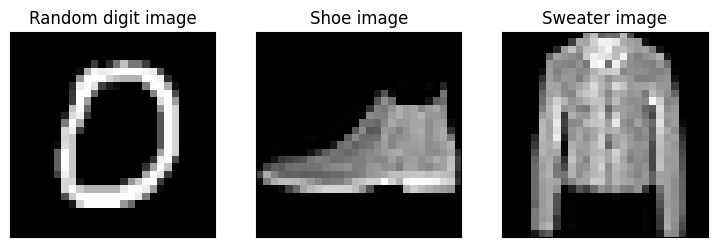

In [3]:
import matplotlib.pyplot as plt
if "conv" in option:
  x_test = np.concatenate((mnist_x_test, fashion_x_test[0].reshape(1, 28, 28), fashion_x_test[10].reshape(1, 28, 28)))
else:
  x_test = np.concatenate((mnist_x_test, fashion_x_test[0].reshape(1,784), fashion_x_test[10].reshape(1,784)))
print(x_test.shape)
plt.gray()

fig = plt.figure(figsize = (9, 3))

ax = fig.add_subplot(1, 3, 1)
plt.title('Random digit image', fontsize = 12)
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False,
                labelbottom = False)
plt.tick_params(axis = 'y', which = 'both', left = False, right = False,
                labelleft = False)

plt.imshow(x_test[10].reshape(28, 28))

ax = fig.add_subplot(1, 3, 2)
plt.title('Shoe image', fontsize = 12)
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False,
                labelbottom = False)
plt.tick_params(axis = 'y', which = 'both', left = False, right = False,
                labelleft = False)
plt.imshow(x_test[10000].reshape(28, 28))

ax = fig.add_subplot(1, 3, 3)
plt.title('Sweater image', fontsize = 12)
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False,
                labelbottom = False)
plt.tick_params(axis = 'y', which = 'both', left = False, right = False,
                labelleft = False)
plt.imshow(x_test[10001].reshape(28, 28))


In [4]:
from keras import layers

def create_autoencoders(feature_layer_dim = 16):
  input_img = keras.Input(shape = (784,), name = 'Input_Layer')
  # 784 is the total number of pixels of MNIST images

  # The layer encoded has a dimension equal to feature_layer_dim and contains
  # the encoded input (therefore the name)
  encoded = layers.Dense(feature_layer_dim, activation = 'relu', name = 'Encoded_Features')(input_img)
  decoded = layers.Dense(784, activation = 'sigmoid', name = 'Decoded_Input')(encoded)

  autoencoder = keras.Model(input_img, decoded)
  encoder = keras.Model(input_img, encoded)

  encoded_input = keras.Input(shape = (feature_layer_dim,))
  decoder = autoencoder.layers[-1]
  decoder = keras.Model(encoded_input, decoder(encoded_input))

  return autoencoder, encoder, decoder

def create_autoencoders_CNN():
  input_img = keras.Input(shape=(28, 28, 1))

  x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
  x = layers.MaxPooling2D((2, 2), padding='same')(x)
  x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = layers.MaxPooling2D((2, 2), padding='same')(x)
  x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

  # at this point the representation is (4, 4, 8) i.e. 128-dimensional

  x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
  x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(16, (3, 3), activation='relu')(x)
  x = layers.UpSampling2D((2, 2))(x)
  decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

  autoencoder = keras.Model(input_img, decoded)
  encoder = keras.Model(input_img, encoded)

  encoded_input = Input(shape=(4, 4, 8))
  decoder_layer = encoded_input
  for layer in autoencoder.layers[7:]:
    decoder_layer = layer(decoder_layer)
  decoder = Model(encoded_input, decoder_layer)

  return autoencoder, encoder, decoder

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 784)]             0         
                                                                 
 Encoded_Features (Dense)    (None, 64)                50240     
                                                                 
 Decoded_Input (Dense)       (None, 784)               50960     
                                                                 
Total params: 101200 (395.31 KB)
Trainable params: 101200 (395.31 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 784)]             0         
                                                                 
 Enc

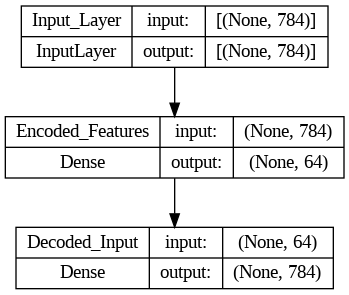

In [5]:
if "conv" in option:
  autoencoder, encoder, decoder = create_autoencoders_CNN()
else:
  autoencoder, encoder, decoder = create_autoencoders(64)
autoencoder.summary()
encoder.summary()
decoder.summary()
keras.utils.plot_model(autoencoder, show_shapes = True)

In [6]:
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

Epoch 1/30
469/469 [==============================] - 8s 8ms/step - loss: 0.1986 - accuracy: 0.0119 - val_loss: 0.1321 - val_accuracy: 0.0129
Epoch 2/30
469/469 [==============================] - 4s 8ms/step - loss: 0.1170 - accuracy: 0.0126 - val_loss: 0.1030 - val_accuracy: 0.0133
Epoch 3/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0968 - accuracy: 0.0117 - val_loss: 0.0893 - val_accuracy: 0.0120
Epoch 4/30
469/469 [==============================] - 3s 6ms/step - loss: 0.0864 - accuracy: 0.0124 - val_loss: 0.0822 - val_accuracy: 0.0130
Epoch 5/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0809 - accuracy: 0.0129 - val_loss: 0.0784 - val_accuracy: 0.0134
Epoch 6/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0781 - accuracy: 0.0126 - val_loss: 0.0764 - val_accuracy: 0.0128
Epoch 7/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0765 - accuracy: 0.0130 - val_loss: 0.0752 - val_accuracy: 0.0115
Epoch 

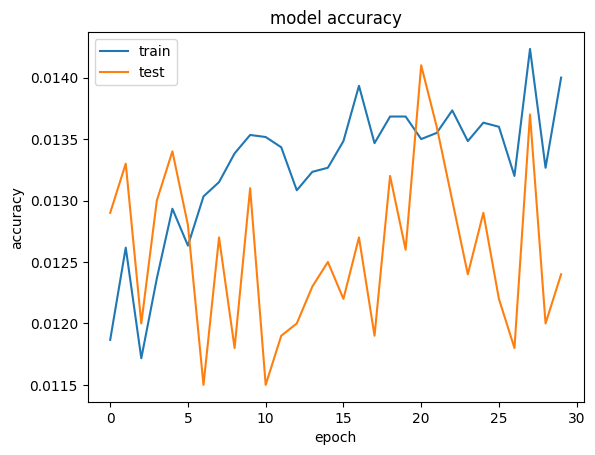

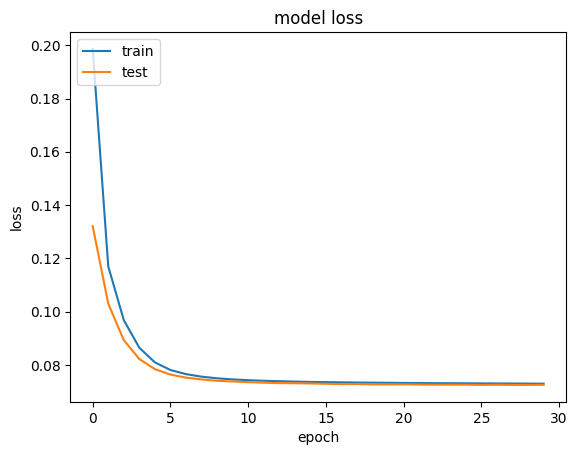

In [7]:
history = autoencoder.fit(mnist_x_train, mnist_x_train,
                          epochs = 30,
                          batch_size = 128,
                          shuffle = True,
                          validation_data = (mnist_x_test, mnist_x_test))

print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

313/313 [==============================] - 1s 1ms/step
Sweater reconstruction error:  0.11023457
Shoe reconstruction error:  0.06569895
Twelve largest reconstruction errors:  [0.01785677 0.01806208 0.01806873 0.01837644 0.01859224 0.01913265
 0.0199516  0.0200768  0.02159002 0.02343037 0.06569895 0.11023457]


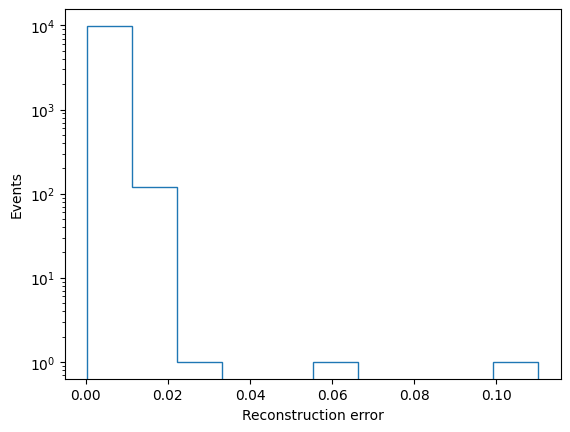

In [8]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# Now define the reconstruction error
if "conv" in option:
  RE = ((x_test.reshape(len(x_test),28*28) - decoded_imgs.reshape(len(decoded_imgs),28*28))**2).mean(axis=1)
else:
  RE = ((x_test - decoded_imgs)**2).mean(axis=1)

RE_original = RE.copy()
print("Sweater reconstruction error: ",RE[-1])
print("Shoe reconstruction error: ",RE[-2])

RE.sort()
print("Twelve largest reconstruction errors: ",RE[9990:])

counts, bins = np.histogram(RE)
plt.stairs(counts, bins)
plt.xlabel('Reconstruction error')
plt.ylabel('Events')
plt.yscale('log')
plt.show()

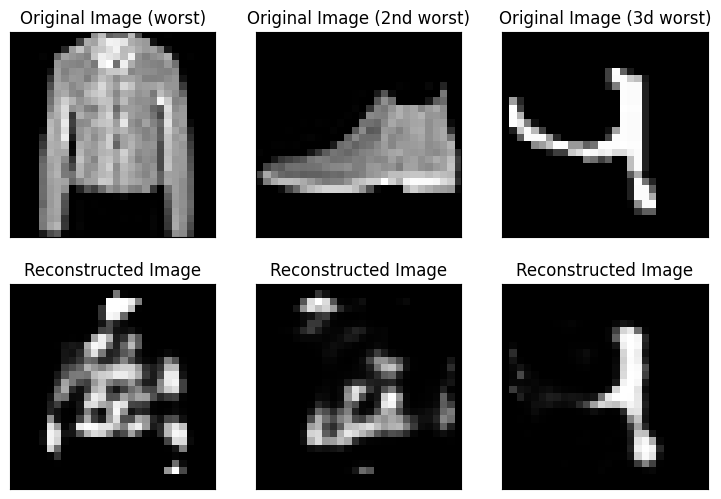

In [9]:
biggest_re_pos = np.argmax(RE_original)
second_biggest_re_pos = list(RE_original).index(RE[-2])
least_re_pos = list(RE_original).index(RE[-3])

fig = plt.figure(figsize = (9, 6))

ax = fig.add_subplot(2, 3, 1)
plt.title('Original Image (worst)', fontsize = 12)

plt.gray()
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False,
                labelbottom = False)
plt.tick_params(axis = 'y', which = 'both', left = False, right = False,
                labelleft = False)

plt.imshow(x_test[biggest_re_pos].reshape(28, 28))

ax = fig.add_subplot(2, 3, 4)
plt.title('Reconstructed Image', fontsize = 12)
plt.gray()
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False,
                labelbottom = False)
plt.tick_params(axis = 'y', which = 'both', left = False, right = False,
                labelleft = False)

plt.imshow(decoded_imgs[biggest_re_pos].reshape(28, 28))

ax = fig.add_subplot(2, 3, 2)
plt.title('Original Image (2nd worst)', fontsize = 12)

plt.gray()
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False,
                labelbottom = False)
plt.tick_params(axis = 'y', which = 'both', left = False, right = False,
                labelleft = False)

plt.imshow(x_test[second_biggest_re_pos].reshape(28, 28))

ax = fig.add_subplot(2, 3, 5)
plt.title('Reconstructed Image', fontsize = 12)
plt.gray()
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False,
                labelbottom = False)
plt.tick_params(axis = 'y', which = 'both', left = False, right = False,
                labelleft = False)

plt.imshow(decoded_imgs[second_biggest_re_pos].reshape(28, 28))

ax = fig.add_subplot(2, 3, 3)
plt.title('Original Image (3d worst)', fontsize = 12)

plt.gray()
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False,
                labelbottom = False)
plt.tick_params(axis = 'y', which = 'both', left = False, right = False,
                labelleft = False)

plt.imshow(x_test[least_re_pos].reshape(28, 28))

ax = fig.add_subplot(2, 3, 6)
plt.title('Reconstructed Image', fontsize = 12)
plt.gray()
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False,
                labelbottom = False)
plt.tick_params(axis = 'y', which = 'both', left = False, right = False,
                labelleft = False)

plt.imshow(decoded_imgs[least_re_pos].reshape(28, 28))